In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint, norm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR

In [14]:
df = pd.read_csv('./data/medical-costs.csv')
df.sample(10)

id   age     sex     bmi  children smoker     region      charges
1172  1172  56.0  female  41.910         0     no  southeast  11093.62290
567    567  41.0    male  30.590         2     no  northwest   7256.72310
1112  1112  48.0  female  25.850         3    yes  southeast  24180.93350
19      19  30.0    male  35.300         0    yes  southwest  36837.46700
134    134  20.0  female  28.785         0     no  northeast   2457.21115
1118  1118  33.0    male  35.750         1    yes  southeast  38282.74950
1049  1049  49.0    male  30.900         0    yes  southwest  39727.61400
1187  1187  62.0  female  32.680         0     no  northwest  13844.79720
1066  1066  48.0    male  37.290         2     no  southeast   8978.18510
1285  1285  47.0  female  24.320         0     no  northeast   8534.67180

<Axes: xlabel='charges', ylabel='Density'>

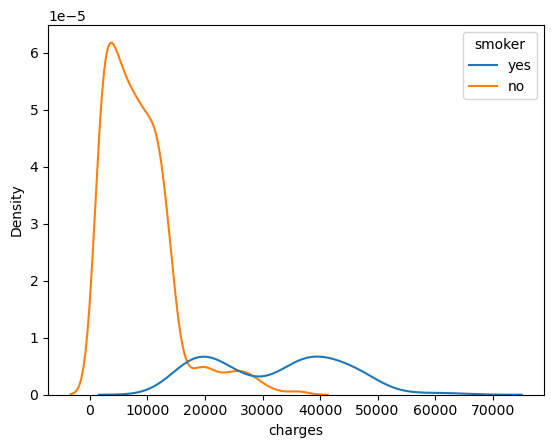

In [15]:
sns.kdeplot(data=df, x='charges', hue='smoker')

In [5]:
df.isna().sum()

age         64
sex          0
bmi          0
children     0
smoker       0
region       0
charges      0
dtype: int64

In [17]:
df.nunique()

id          1338
age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [18]:
transformer = ColumnTransformer(transformers=[
    ('dropper', 'drop', ['id']),
    ('imputer', SimpleImputer(strategy='mean'), ['age']),
    ('one_hot', OneHotEncoder(), ['sex', 'smoker', 'region']),
], remainder='passthrough')

pipeline = Pipeline([
    ('column_transformer', transformer),
    ('scaler', RobustScaler())
])

X = df.drop(columns='charges')
y = df.charges
transformed = pipeline.fit_transform(X)
transformed = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

In [19]:
X = df.drop(columns='charges')
y = df.charges
X_train, X_test, y_train, y_test = train_test_split(transformed, y, test_size=0.2, random_state=42)

In [20]:
def calc_error(model, X_test, y_true):
    predictions = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_true, predictions))

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
calc_error(lin_reg, X_test, y_test)

5881.12335412996

In [22]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
calc_error(forest, X_test, y_test)

4810.597315296783

In [23]:
svm = SVR()
svm.fit(X_train, y_train)
calc_error(svm, X_test, y_test)

12887.866677284585

### RandomForest erscheint am vielversprechendsten

# Hyperparameter tuning

*Hyperparameter* - werden von Menschen gesetzt, **nicht** vom model gelernt; vor allem Konstruktorparameter


![flow](./assets/grid_search_workflow.png)

<Axes: >

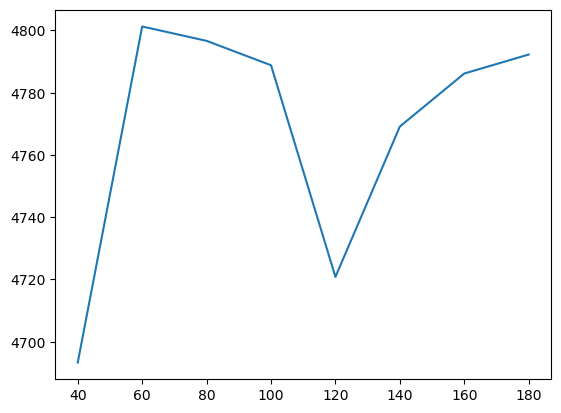

In [24]:
errors = {}
for n in range(40, 200, 20):
    forest = RandomForestRegressor(n_estimators=n)
    forest.fit(X_train, y_train)
    errors[n] = calc_error(forest, X_test, y_test)

sns.lineplot(data=errors, x=errors.keys(), y=errors.values())

### Testset soll unbekannte Daten simulieren ==> nicht zum Trainieren verwenden

![cv](./assets/grid_search_cross_validation.png)

In [25]:
params = {'n_estimators': range(50, 300, 50),
          'max_features': [1.0, 'sqrt', 'log2']}
grid = GridSearchCV(estimator=RandomForestRegressor(),
                    param_grid=params,
                    scoring='neg_mean_squared_error',  # -mse, damit höher=besser
                    cv=5,
                    n_jobs=4)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_features': [1.0, 'sqrt', 'log2'],
                         'n_estimators': range(50, 300, 50)},
             scoring='neg_mean_squared_error')

In [26]:
pd.DataFrame(grid.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.185942      0.007312         0.008192        0.002316   
1        0.350816      0.008954         0.012825        0.001609   
2        0.519399      0.008917         0.015593        0.001190   
3        0.677126      0.006168         0.020229        0.001891   
4        0.833286      0.005353         0.023109        0.002129   
5        0.092120      0.003753         0.005667        0.000518   
6        0.179819      0.002700         0.012144        0.003711   
7        0.275879      0.005315         0.014130        0.001744   
8        0.364062      0.010220         0.019373        0.002327   
9        0.456500      0.010698         0.025977        0.003643   
10       0.091580      0.003874         0.006255        0.001178   
11       0.184257      0.008203         0.010832        0.001296   
12       0.281399      0.006037         0.015492        0.001747   
13       0.362606      0.007681         0.022007        0.004338   
14       0.446241      0.014282         0.020747        0.003549   

   param_max_features param_n_estimators  \
0                 1.0                 50   
1                 1.0                100   
2                 1.0                150   
3                 1.0                200   
4                 1.0                250   
5                sqrt                 50   
6                sqrt                100   
7                sqrt                150   
8                sqrt                200   
9                sqrt                250   
10               log2                 50   
11               log2                100   
12               log2                150   
13               log2                200   
14               log2                250   

                                           params  split0_test_score  \
0       {'max_features': 1.0, 'n_estimators': 50}      -2.613685e+07   
1      {'max_features': 1.0, 'n_estimators': 100}      -2.557919e+07   
2      {'max_features': 1.0, 'n_estimators': 150}      -2.553371e+07   
3      {'max_features': 1.0, 'n_estimators': 200}      -2.598161e+07   
4      {'max_features': 1.0, 'n_estimators': 250}      -2.616732e+07   
5    {'max_features': 'sqrt', 'n_estimators': 50}      -2.599877e+07   
6   {'max_features': 'sqrt', 'n_estimators': 100}      -2.544036e+07   
7   {'max_features': 'sqrt', 'n_estimators': 150}      -2.444460e+07   
8   {'max_features': 'sqrt', 'n_estimators': 200}      -2.446432e+07   
9   {'max_features': 'sqrt', 'n_estimators': 250}      -2.426972e+07   
10   {'max_features': 'log2', 'n_estimators': 50}      -2.442458e+07   
11  {'max_features': 'log2', 'n_estimators': 100}      -2.464820e+07   
12  {'max_features': 'log2', 'n_estimators': 150}      -2.456142e+07   
13  {'max_features': 'log2', 'n_estimators': 200}      -2.385095e+07   
14  {'max_features': 'log2', 'n_estimators': 250}      -2.434602e+07   

    split1_test_score  split2_test_score  split3_test_score  \
0       -1.577831e+07      -2.660206e+07      -3.350329e+07   
1       -1.646917e+07      -2.614446e+07      -3.276295e+07   
2       -1.661702e+07      -2.559843e+07      -3.323701e+07   
3       -1.648452e+07      -2.590920e+07      -3.277016e+07   
4       -1.657148e+07      -2.604335e+07      -3.269239e+07   
5       -1.578920e+07      -2.452931e+07      -3.145872e+07   
6       -1.617309e+07      -2.439195e+07      -3.203905e+07   
7       -1.634486e+07      -2.484290e+07      -3.137172e+07   
8       -1.552133e+07      -2.483418e+07      -3.113176e+07   
9       -1.581588e+07      -2.392630e+07      -3.120331e+07   
10      -1.613363e+07      -2.454019e+07      -3.132264e+07   
11      -1.612852e+07      -2.416464e+07      -3.163053e+07   
12      -1.532045e+07      -2.409550e+07      -3.144867e+07   
13      -1.611641e+07      -2.464622e+07      -3.133109e+07   
14      -1.586102e+07      -2.458601e+07      -3.173218e+07   

    split4_test_score  mean_test_score  std_test

In [29]:
calc_error(grid.best_estimator_, X_test, y_test)

4821.825820380032

![grid vs random](./assets/grid_vs_random.png)

In [30]:
grid = RandomizedSearchCV(estimator=RandomForestRegressor(),
                          param_distributions={'n_estimators': randint(0, 1000),
                                               'max_features': norm(loc=0.5, scale=0.15)},
                          scoring='neg_mean_squared_error',  # -mse, damit höher=besser
                          cv=5,
                          n_jobs=4,
                          verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13f4015d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13c743210>},
                   scoring='neg_mean_squared_error', verbose=1)

In [32]:
grid.best_estimator_

RandomForestRegressor(max_features=0.49184276325909515, n_estimators=935)

In [31]:
calc_error(grid.best_estimator_, X_test, y_test)

4669.437328517219